# EPIC220208795 - Orbital Analysis

Using the light curve data, the parameters obtained from the eclipse fit and all the remaining photometry from ground surveys we can do orbital analysis. This is based in large part on the size of the disk, stability criteria and the transverse velocity found.

1) the transverse velocity tells you what the circular velocity would be for a Keplerian orbit. If this is not believeable we can attempt to "fit" an elliptical orbit by constructing a grid of secondary masses and periods

2) the size of the disk can give a minimum mass constraint based on the formula for the Hill radius of the secondary

In [1]:
import os
import numpy as np
import astropy.units as u
import astropy.constants as c
import matplotlib.pyplot as plt
from Code import orbital_analysis as oa

%matplotlib inline

## Stellar and Disk Parameters

Here we define the stellar parameters (magnetic and standard models help determine the mass and radius is determined from $v \sin i$ values) and disk parameters from the eclipse modeling notebook.

### Stellar Parameters

In [2]:
#EPIC220208795
Ms = 0.850 * u.Msun
Rs = 0.830 * u.Rsun

### Hard-edged disk (from 'small disk run')

In [3]:
# load parameters
pb_osd = np.load('models 2202/small_disk_run_2202.npy')
saveroot_osd = 'plots 2202/parameters/small_disk_run_2202_new/'

# extract parameters
if len(pb_osd) == 6:
    rdisk_osd, b_osd, inc_osd, tilt_osd, vt_osd, dt_osd = pb_osd
    redge_osd = tau_edge_osd = tau_disk_osd = 0
elif len(pb_osd) == 7:
    rdisk_osd, b_osd, inc_osd, tilt_osd, vt_osd, dt_osd, tau_disk_osd = pb_osd
    redge_osd = tau_edge_osd = 0
else:
    rdisk_osd, b_osd, inc_osd, tilt_osd, vt_osd, dt_osd, tau_disk_osd, tau_edge_osd = pb_osd
    
# calculate total size
rtot_osd = rdisk_osd + redge_osd

# transform to SI units
rs_osd = (rtot_osd * Rs).to(u.au)

# convert to km/s
vs_osd = (vt_osd * Rs / u.day).to(u.km / u.s)

print('radius disk: %.4f %s' % (rs_osd.value, rs_osd.unit))
print('velocity: %.4f %s' % (vs_osd.value, vs_osd.unit))

radius disk: 0.0053 AU
velocity: 77.4492 km / s


### Soft-edged disk run ('fuzzy small disk')

In [4]:
# load parameters
pb_osf = np.load('models 2202/fuzzy_small_disk_run_2202.npy')
saveroot_osf = 'plots 2202/parameters/fuzzy_small_disk_run_2202_new/'

# extract parameters
if len(pb_osf) == 6:
    rdisk_osf, b_osf, inc_osf, tilt_osf, vt_osf, dt_osf = pb_osf
    redge_osf = tau_edge_osf = tau_disk_osf = 0
elif len(pb_osf) == 7:
    rdisk_osf, b_osf, inc_osf, tilt_osf, vt_osf, dt_osf, tau_disk_osf = pb_osf
    redge_osf = tau_edge_osf = 0
else:
    rdisk_osf, redge_osf, b_osf, inc_osf, tilt_osf, vt_osf, dt_osf, tau_edge_osf = pb_osf
    tau_disk_osf = 0
    
# calculate total size
rtot_osf = rdisk_osf + redge_osf

# transform to SI units
rs_osf = (rtot_osf * Rs).to(u.au)

# convert to km/s
vs_osf = (vt_osf * Rs / u.day).to(u.km / u.s)

print('radius disk: %.4f %s' % (rs_osf.value, rs_osf.unit))
print('velocity: %.4f %s' % (vs_osf.value, vs_osf.unit))


radius disk: 0.0057 AU
velocity: 76.8626 km / s


## Circular Orbit

We start with the limiting case, where we assume that the secondary is on a circular orbit. $\ \ \ \ \ \ \ \ m\frac{v_{circ}^2}{r} = \frac{GmM}{r^2} \rightarrow r = \frac{GM}{v_{circ}^2}$

In [5]:
# find semi-major axis for a keplerian orbit
#hard-edged disk
a_circ_osd = oa.vcirc_to_a(Ms, 0*u.Mjup, vs_osd)
print('semimajor axis hard-edged disk: %.4f %s' % (a_circ_osd.value, a_circ_osd.unit))

semimajor axis hard-edged disk: 0.1257 AU


In [6]:
#soft-edged disk
a_circ_osf = oa.vcirc_to_a(Ms, 0*u.Mjup, vs_osf)
print('semimajor axis soft-edged disk: %.4f %s' % (a_circ_osf.value, a_circ_osf.unit))

semimajor axis soft-edged disk: 0.1276 AU


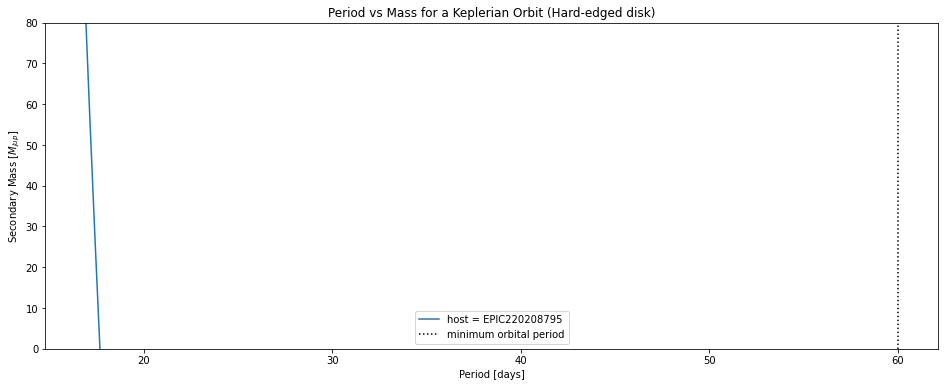

In [7]:
# find the relevant periods (which depend on mass of the secondary)
Mp = np.linspace(0, 80, 801) * u.Mjup

#hard-edged disk
plt.figure(figsize=(16,6))
plt.title('Period vs Mass for a Keplerian Orbit (Hard-edged disk)')
P = oa.a_to_P(a_circ_osd, Ms, Mp).to(u.day)
plt.plot(P, Mp, label='host = EPIC220208795')
plt.axvline(x=60, label='minimum orbital period', color='k', ls=':')
plt.ylim(0, 80)
plt.ylabel('Secondary Mass [$M_{jup}$]')
plt.xlabel('Period [days]')
plt.legend()
plt.show()

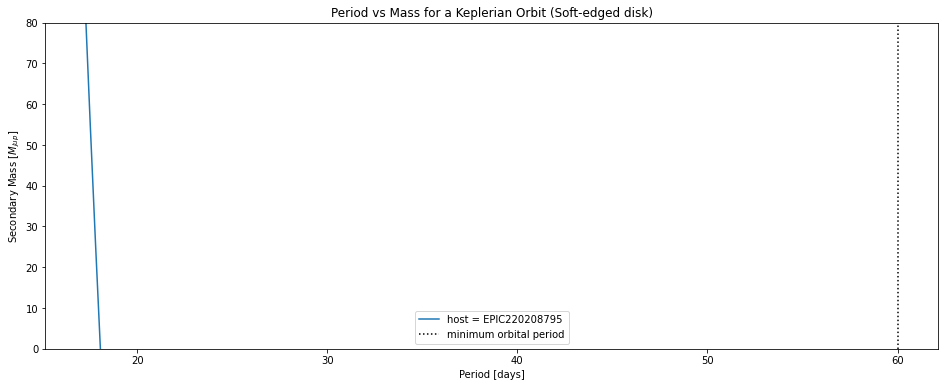

In [8]:
# find the relevant periods (which depend on mass of the secondary)
Mp = np.linspace(0, 80, 801) * u.Mjup

#hard-edged disk
plt.figure(figsize=(16,6))
plt.title('Period vs Mass for a Keplerian Orbit (Soft-edged disk)')
P = oa.a_to_P(a_circ_osf, Ms, Mp).to(u.day)
plt.plot(P, Mp, label='host = EPIC220208795')
plt.axvline(x=60, label='minimum orbital period', color='k', ls=':')
plt.ylim(0, 80)
plt.ylabel('Secondary Mass [$M_{jup}$]')
plt.xlabel('Period [days]')
plt.legend()
plt.show()

This plot implies that for a circular orbit with a period exceeding 66 days the mass of the secondary must be negative, which is of course impossible. We must assume that the orbit is thus eccentric.

## Eccentric Orbit

Now we need to construct mass, period grids to do "simulations" to see what possible orbital configurations are possible. Our basic constraints are as follows:

1) we have a periastron velocity given by the eclipse fit

3) the Hill radius must exceed the size of the disk with a stability factor ($0.3 \, r_{Hill} > r_{disk}$)

4) the disk must be stable at periastron passage (so $r_{Hill}$ evaluated at $r_{peri}$)

5) the period must exceed 60 days ($P > 60$ days)

### Parameter Constraints

In [9]:
# parameter limits hard-edged disk
rap_max = 10 * u.au                        # very high max
rh_min_osd  = rs_osd/0.3                   # minimum Hill radii

# companion limits
P_min  = 60 * u.day                         # otherwise visible in K2 photometry
Mp_min = 0  * u.Mjup                        # the planet can't have mass less than 0
Mp_max = 80 * u.Mjup                        # the planet shouldn't exceed the substellar mass limit

# eclipse parameters
t_ecl = 0.3 * u.day                         # eclipse duration
d_ecl = 0.7                                 # eclipse depth

In [10]:
# parameter limits soft-edged disk
rap_max = 10 * u.au                        # very high max
rh_min_osf  = rs_osf/0.3 # minimum Hill radii

# companion limits
P_min  = 60 * u.day                         # otherwise visible in K2 photometry
Mp_min = 0  * u.Mjup                        # the planet can't have mass less than 0
Mp_max = 80 * u.Mjup                        # the planet shouldn't exceed the substellar mass limit

# eclipse parameters
t_ecl = 0.3 * u.day                         # eclipse duration
d_ecl = 0.7                                 # eclipse depth

### Setting-up Mass and Period Grids

In [11]:
# we make a mass grid
Mp = np.linspace(Mp_min, Mp_max, int((Mp_max - Mp_min).value) + 1)

# we can determine the maximum period by saying that the semi-major axis in a circular orbit may not exceed rap_max
P_max = 0

P = np.ceil(oa.a_to_P(rap_max, Ms, Mp_min).to(u.day)) # round number of days
if P > P_max:
    P_max = P

# we make a period grid
P = np.linspace(P_min, P_max, int((P_max - P_min).value) + 1)

# we print the parameters
print('Mass range is:   %.1f - %.1f %s' % (Mp_min.value, Mp_max.value, Mp.unit))
print('Period range is: %d - %d %s' % (P_min.value, P_max.value, P.unit))

Mass range is:   0.0 - 80.0 jupiterMass
Period range is: 60 - 12529 d


### Determining Parameters

Here we look at the parameters themselves and see if there is a large amount of parameter space that is blocked out by the constraints. The simplest constraints are those on $r_{Hill}$ and $r_{ap}$ as these are not dependent on the data collected from ground surveys. We therefore start with these constraints.

In [12]:
#hard-edged disk
e_osd, rp_osd, rap_osd, rh_osd = oa.get_parameters(Ms, Mp, P, vs_osd)

In [13]:
#soft-edged disk
e_osf, rp_osf, rap_osf, rh_osf = oa.get_parameters(Ms, Mp, P, vs_osf)

### Determining Extent of Period and Mass

The most obvious parameter to check the apastron distance $r_{ap}$ as this likely has the largest cut-off due to a strict constraint, but we enforce the constraint on apastron distance and the Hill radius.

In [14]:
#Plot parameters

SMALL_SIZE = 8*2                                        
MEDIUM_SIZE = 12*2
BIGGER_SIZE = 16*2

plt.rc('font', size=MEDIUM_SIZE, family='serif')          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)                     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)                     # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE, direction='in')    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE, direction='in')    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)                    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)                  # fontsize of the figure title
plt.rc('figure', figsize='8, 6')                         # size of the figure, used to be '4, 3' in inches

In [15]:
#hard-edged disk
# define
rh_mask_osd  = rs_osd.value <= 0.3 * rh_osd.value

In [16]:
#soft-edged disk
# define
rh_mask_osf  = rs_osf.value <= 0.3 * rh_osf.value

# Parameter Maps

Here all the parameter maps are prepared with a high resolution grid for 2 situations: the hard-edged and soft-edged model. The parameters considered are the apastron distance $r_{ap}$, periastron distance $r_{peri}$ the eccentricity $e$ and the Hill radius $r_H$.

In [17]:
# maximum obtained from period folding
Mp_minn = 0 * u.Mjup
Mp_maxn = 80 * u.Mjup
P_minn = 60 * u.day
P_maxn = 1800 * u.day

# new resolution grid
Mpn = np.linspace(Mp_minn, Mp_maxn, 10 * int((Mp_maxn - Mp_minn).value) + 1)
Pn  = np.linspace(P_minn, P_maxn, 10 * int((P_maxn - P_minn).value) + 1)

In [18]:
#hard-edged disk
en_osd, rpn_osd, rapn_osd, rhn_osd = oa.get_parameters(Ms, Mpn, Pn, vs_osd)

In [19]:
#soft-edged disk
en_osf, rpn_osf, rapn_osf, rhn_osf = oa.get_parameters(Ms, Mpn, Pn, vs_osf)

In [20]:
#hard-edged disk
rh_maskn_osd  = rs_osd.value <= 0.3 * rhn_osd.value

In [21]:
#soft-edged disk
rh_maskn_osf  = rs_osf.value <= 0.3 * rhn_osf.value

In [22]:
# save labels for the zoomed in plots
savebases_235 = '%s_2202_235.pdf'
savebases_osd_235 = '%s_2202_new_235.pdf'
savebases_osf_235 = '%s_2202_new_fuzzy_235.pdf'

savebases_290 = '%s_2202_290.pdf'
savebases_osd_290 = '%s_2202_new_290.pdf'
savebases_osf_290 = '%s_2202_new_fuzzy_290.pdf'

In [23]:
# save labels for the full plot
savebases_1800 = '%s_2202_1800.pdf'
savebases_osd_1800 = '%s_2202_new_1800.pdf'
savebases_osf_1800 = '%s_2202_new_fuzzy_1800.pdf'

## Making plots

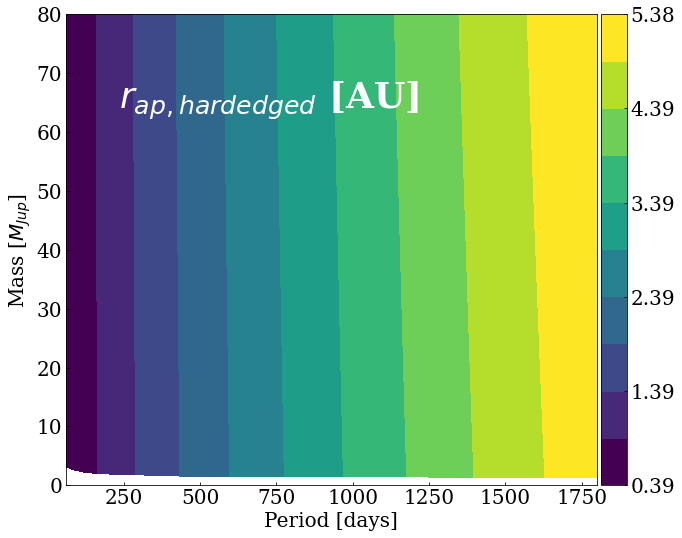

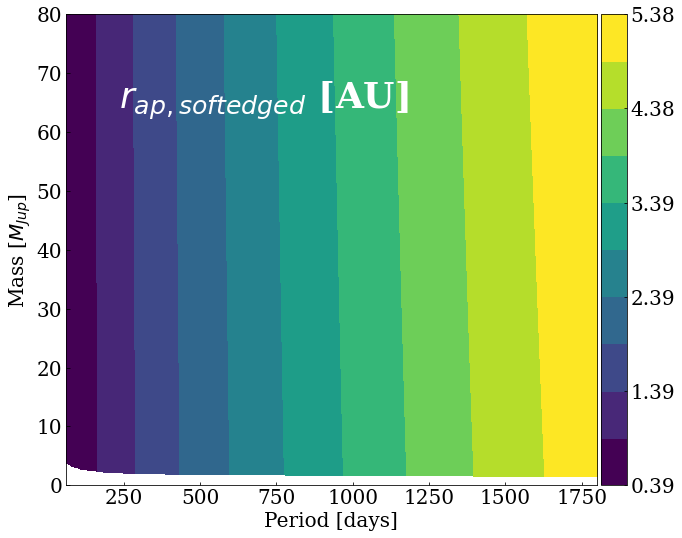

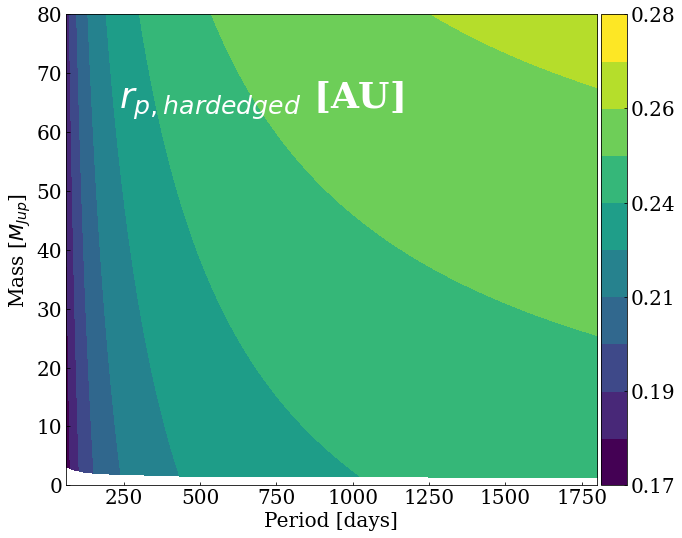

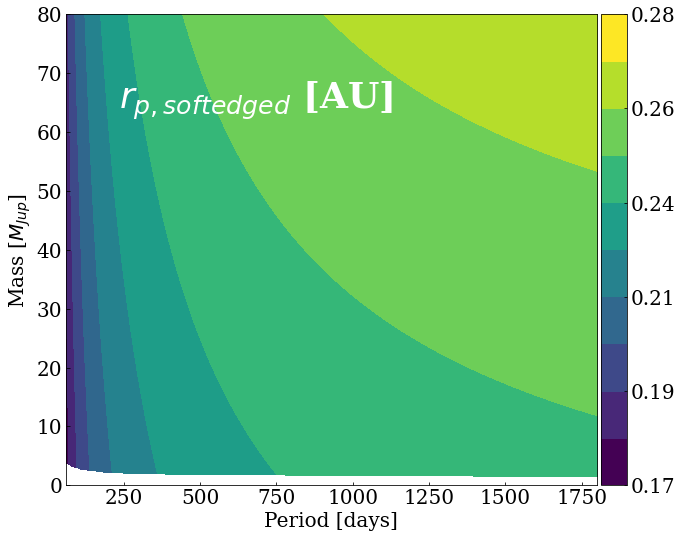

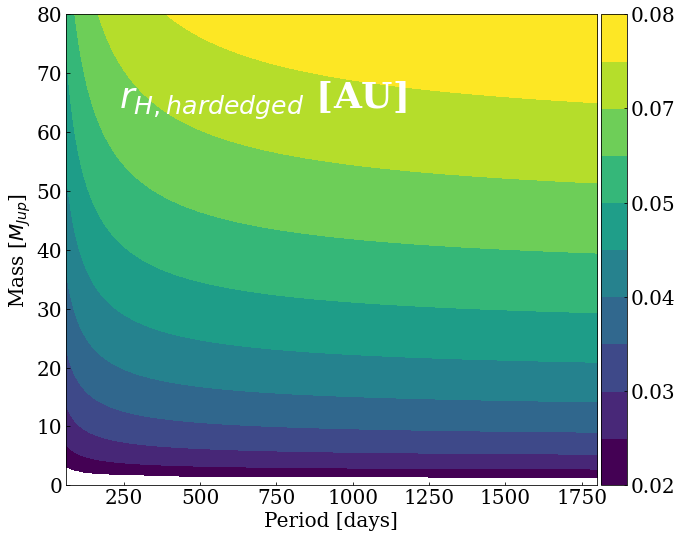

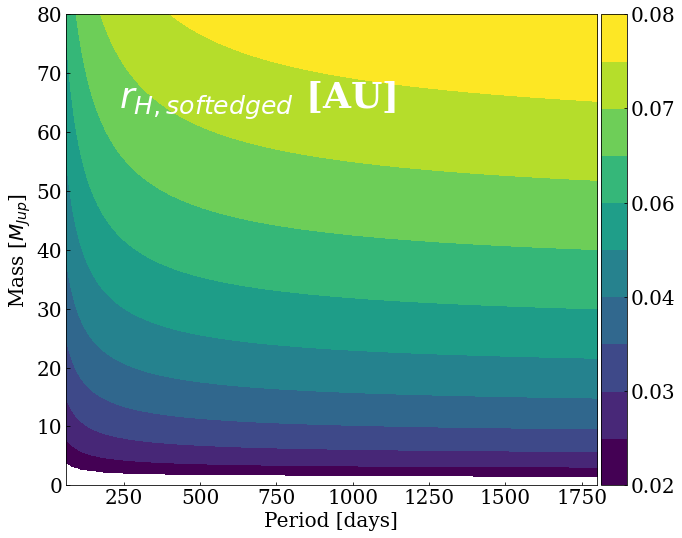

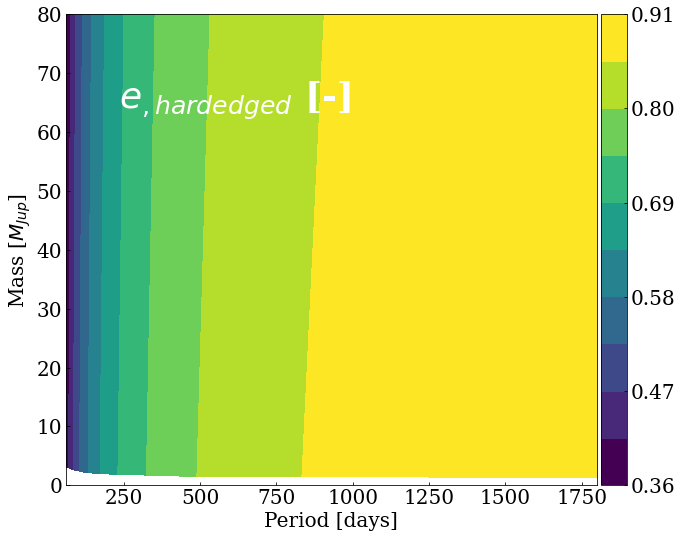

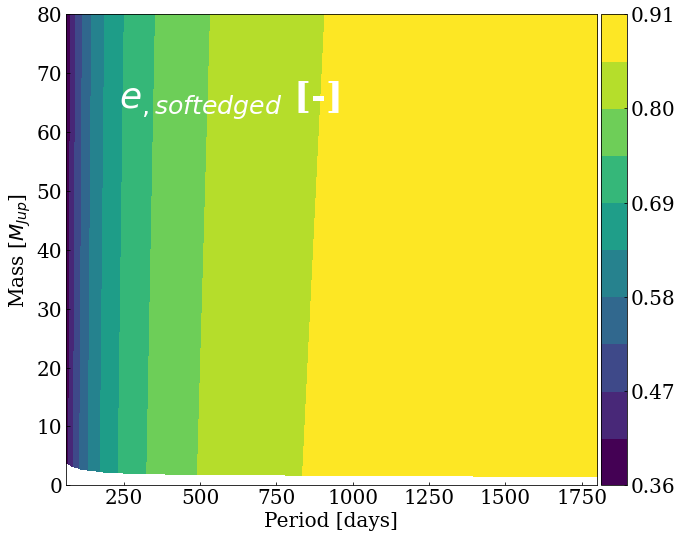

In [24]:
## Apastron Passage - $r_{ap}$

#hard-edged disk
lbl_osd = '$%s hard edged}$'
savename_osd_1800 = saveroot_osd + savebases_osd_1800 % 'rap'
param_osd = lbl_osd % 'r_{ap, '
oa.plot_parameter(Pn, Mpn, rapn_osd, param_osd, rh_mask=rh_maskn_osd, savename=savename_osd_1800, title_color='w')

#soft-edged disk
lbl_osf = '$%s soft edged}$'
savename_osf_1800 = saveroot_osf + savebases_osf_1800 % 'rap'
param_osf = lbl_osf % 'r_{ap, '
oa.plot_parameter(Pn, Mpn, rapn_osf, param_osf, rh_mask=rh_maskn_osf, savename=savename_osf_1800, title_color='w')


## Periastron Passage - $r_p$

#hard-edged disk
save_osd_1800 = saveroot_osd + savebases_osd_1800 % 'rp'
param_osd = lbl_osd % 'r_{p, '
oa.plot_parameter(Pn, Mpn, rpn_osd, param_osd, rh_mask=rh_maskn_osd, savename=save_osd_1800, title_color='w', vmin=0.17, vmax=0.28)

#soft-edged disk
save_osf_1800 = saveroot_osf + savebases_osf_1800 % 'rp'
param_osf = lbl_osf % 'r_{p, '
oa.plot_parameter(Pn, Mpn, rpn_osf, param_osf, rh_mask=rh_maskn_osf, savename=save_osf_1800, title_color='w', vmin=0.17, vmax=0.28)


## Hill Radius - $r_H$

#hard-edged disk
save_osd_1800 = saveroot_osd + savebases_osd_1800 % 'rh'
param_osd = lbl_osd % 'r_{H, '
oa.plot_parameter(Pn, Mpn, rhn_osd, param_osd, rh_mask=rh_maskn_osd, savename=save_osd_1800, title_color='w')

#soft-edged disk
save_osf_1800 = saveroot_osf + savebases_osf_1800 % 'rh'
param_osf = lbl_osf % 'r_{H, '
oa.plot_parameter(Pn, Mpn, rhn_osf, param_osf, rh_mask=rh_maskn_osf, savename=save_osf_1800, title_color='w')


## Eccentricity - $e$

#hard-edged disk
save_osd_1800 = saveroot_osd + savebases_osd_1800 % 'e'
param_osd = lbl_osd % 'e_{, '
oa.plot_parameter(Pn, Mpn, en_osd, param_osd, rh_mask=rh_maskn_osd, savename=save_osd_1800, title_color='w')

#soft-edged disk
save_osf_1800 = saveroot_osf + savebases_osf_1800 % 'e'
param_osf = lbl_osf % 'e_{, '
oa.plot_parameter(Pn, Mpn, en_osf, param_osf, rh_mask=rh_maskn_osf, savename=save_osf_1800, title_color='w')

